In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

from backgroung import plot_map
import bgcalc_xr as bgxr

In [2]:
model_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
model = xr.open_dataset(model_path)

In [3]:
# Grid projection setting
llcrnrlat=22.85
llcrnrlon=-97.9
urcrnrlat=30.5
urcrnrlon=-87.5
lon_0 = (llcrnrlon+urcrnrlon)*0.5
extent=[llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat]
p = ccrs.PlateCarree(central_longitude=lon_0)

#Define region of interest
hmin = 10.
hmax = 50.
mab = 5

lonl = -95
lonr = -91
latl = 28.
latu = 29.6

ROI =(model.h>=hmin)&(model.h<=hmax)& \
    (model.coords['lon_rho']>=lonl)&(model.coords['lon_rho']<=lonr)& \
    (model.coords['lat_rho']>=latl)& (model['lat_rho'] < latu)& \
    (model.mask_rho==1)
ROI[161:166,274:279]=False
model.coords['mask2D'] = (('eta_rho', 'xi_rho'), ROI)

In [4]:
ds = bgxr.Calculator(model)

/Users/vrx/miniconda3/envs/owl/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [5]:
tidx = 0
ds.subset('2010-08-01T00')
rate = ds.get_intrate()
SOD = ds.get_btmflux()

In [6]:
uadv , vadv = ds.get_inthadv()

In [8]:
diverg = ds.get_divergence()

In [9]:
vort = ds.get_vorticity()

In [12]:
start = time.time()
vadv = ds.advflux_z()
end = time.time()

print(end-start)
vadv.to_netcdf('vadv.nc')

5438.007574081421


In [22]:
ls

Whole_grid.png        bgcalc_example.ipynb  vadv.nc
axis_positions.svg    vadv                  xgcm_roms.ipynb


Variable name and units not found. Use cb.set_label('<something >') to set colorbar label
Time stamp not found


(<Figure size 1200x600 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x126636748>)

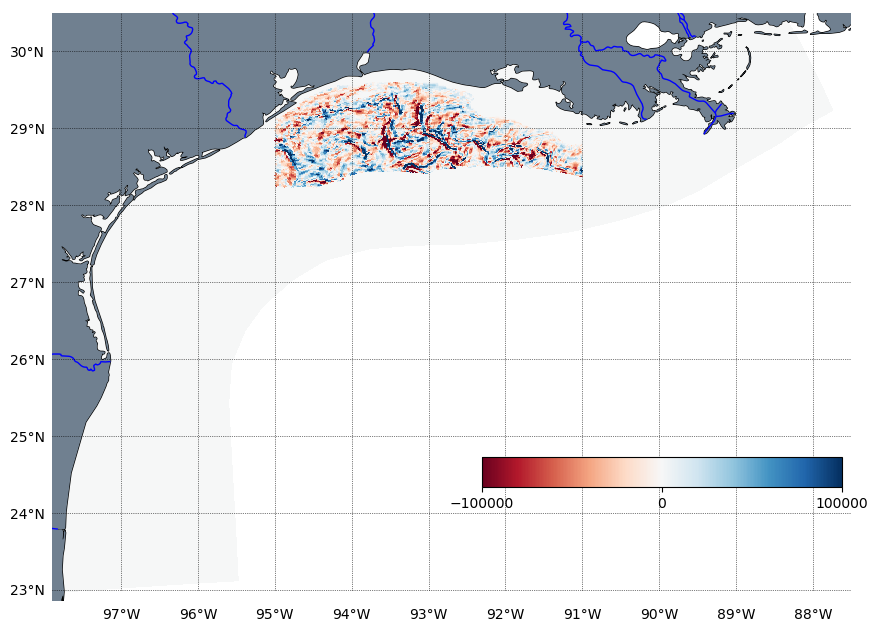

In [18]:
plot_map(ds.ds.lon_rho, ds.ds.lat_rho, vadv, vmin=-1e5, vmax=1e5)

In [11]:
from scipy.interpolate import interp1d
import time

In [38]:
flux = xr.zeros_like(ds.zmab)
Js, Is = np.where(ds.ROI == 1)

def get_vflux(ds, point):
    j = point[0]
    i = point[1]
    colum = ds.ds.isel(eta_rho=j, xi_rho=i)
    
    var = ds.ds.isel(eta_rho=j, xi_rho=i)[ds.var]
    w = ds.ds.isel(eta_rho=j, xi_rho=i)['w']
    
    stg_depths = ds.z_w.isel(eta_rho=j, xi_rho=i)
    var_depths = ds.z_rho.isel(eta_rho=j, xi_rho=i)
    zmab = ds.zmab.isel(eta_rho=j, xi_rho=i)
    
    fw_z = interp1d(stg_depths, w)
    if zmab >= var_depths[-1]:
        if zmab >= stg_depths[-1]:
            flux[j, i] = 0.
        else:
            flux[j, i] = fw_z(zmab) * var[-1]
    elif zmab <= var_depths[0]:
        flux[j, i] = fw_z(zmab) * var[0]
    else:
        fvar_z = interp1d(var_depths, var)
        flux[j, i] = fw_z(zmab) * fvar_z(zmab)

In [36]:
from concurrent.futures import ThreadPoolExecutor

In [39]:
e = ThreadPoolExecutor(8)

points = zip(Js, Is)

e.map(get_vflux,points)

<generator object Executor.map.<locals>.result_iterator at 0x12df8c360>